In [2]:
# In[0]

import torch 
import torch.nn as nn
import os
from PIL import Image
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary

# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# cristian path 
base_dir = '/home/csalitre/school/ecgr-5106/final-project/' 

train_path = base_dir + 'semantic-segmentation/train2/' 
valid_path = base_dir + 'semantic-segmentation/valid2/'
test_path = base_dir + 'semantic-segmentation/test2/'

image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Custom DiceLoss for training
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets, smooth=1e-6):
        intersection = torch.sum(logits * targets)
        dice_coefficient = (2. * intersection + smooth) / (torch.sum(logits) + torch.sum(targets) + smooth)
        return 1.0 - dice_coefficient

class BrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

        # Print lengths of image_files and mask_files for debugging
        print(f"Length of image files: {len(self.image_files)}")
        print(f"Length of mask files: {len(self.mask_files)}")

     # Check consistency of image and mask files
        if len(self.image_files) != len(self.mask_files):
            mismatched_file_index = len(self.image_files) if len(self.image_files) < len(self.mask_files) else len(self.mask_files)
            print(f"Mismatched files: {self.image_files[mismatched_file_index]}")
            raise ValueError("Number of images and masks do not match.")
    
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self,idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image_gray = Image.open(img_path).convert("L")  # Convert to grayscale
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)
        return image_gray, mask



train_dataset = BrainDataset(train_path, transform=image_transform)
valid_dataset = BrainDataset(valid_path, transform=image_transform)
test_dataset = BrainDataset(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define cnn encoder-decoder model
class CNN_EncoderDecoder(nn.Module):
    def __init__(self,in_chans=1, out_chans=32, sampling_factor=2):
        super(CNN_EncoderDecoder, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=sampling_factor),
            nn.Conv2d(out_chans, out_chans * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=sampling_factor))
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(out_chans * 2 , out_chans, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_chans, in_chans, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    # Define loss function
    criterion = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to device
    model.to(device)
    summary(model, (1, 256, 256))
    
    
    train_loss_history = []
    valid_loss_history = []
    all_vlabels =  []
    all_vpreds = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train =0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad() # zero out the gradients
            outputs = model(images)
            #print(outputs.shape)
            loss = criterion(outputs, masks)

            loss.backward() # back propagate the loss
            optimizer.step()    # update the weights
            train_loss += loss.item() # add the loss to the train loss

            predicted = outputs > 0.5   # threshold the outputs to get the predicted masks
            correct_train += (predicted == masks).sum().item()
            total_train += masks.numel()

        train_accuracy = correct_train / total_train

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                valid_loss += loss.item()

                predicted = outputs > 0.5
                correct_valid += (predicted == masks).sum().item()
                total_valid += masks.numel()

                all_vpreds.extend(predicted.view(-1).cpu().numpy())
                all_vlabels.extend(masks.view(-1).cpu().numpy())

        valid_accuracy = correct_valid / total_valid

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train loss: {train_loss/len(train_loader):.4f}, "
               f"Train accuracy: {train_accuracy:.4f}, "
               f"Validation loss: {valid_loss/len(valid_loader):.4f}, "
               f"Validation accuracy: {valid_accuracy:.4f}")
        
        # Save the loss values for plotting
        train_loss_history.append(train_loss/len(train_loader))
        valid_loss_history.append(valid_loss/len(valid_loader))

    return model, train_loss_history, valid_loss_history, all_vlabels, all_vpreds


model = CNN_EncoderDecoder()
model, train_loss_history, valid_loss_history = train(model, train_loader, valid_loader, num_epochs=20, learning_rate=0.001)



Length of image files: 1501
Length of mask files: 1501
Length of image files: 429
Length of mask files: 429
Length of image files: 215
Length of mask files: 215
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
   ConvTranspose2d-7         [-1, 32, 128, 128]           8,224
              ReLU-8         [-1, 32, 128, 128]               0
   ConvTranspose2d-9          [-1, 1, 256, 256]             129
          Sigmoid-10          [-1, 1, 256, 256]               0
Total params: 27,169
Trainable params: 27,169
Non-trainable params: 0


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# Compute and plot the confusion matrix
cm = confusion_matrix(all_vlabels, all_vpreds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Object'], yticklabels=['Background', 'Object'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

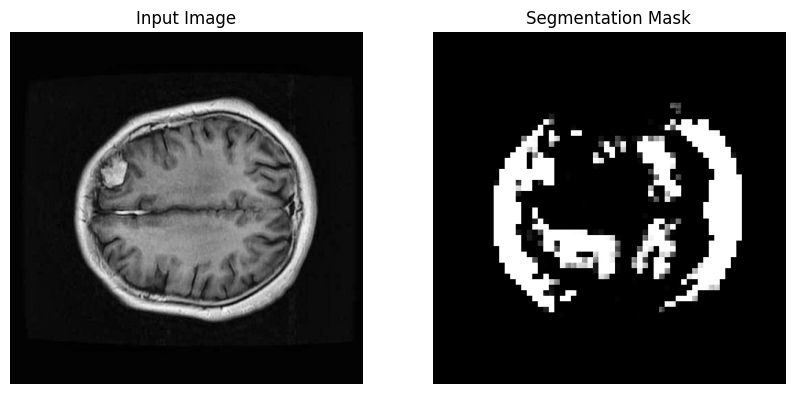

In [4]:
# Save the trained model
torch.save(model.state_dict(), os.path.join(base_dir, 'cnn_encoderdecoder.pth'))

# Load the trained model
model.load_state_dict(torch.load(os.path.join(base_dir, 'cnn_encoderdecoder.pth')))
model.eval()

# Run inference on a sample image
image_path = os.path.join(base_dir, "semantic-segmentation/test2/images/27_jpg.rf.b2a2b9811786cc32a23c46c560f04d07.jpg")
image = Image.open(image_path).convert("L")
input_image = image_transform(image).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(input_image)
output_np = output.squeeze(0).cpu().numpy()

# Plot the input image and the segmentation mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_np[0], cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')
plt.show()